# **Atmosphere Sanity Check**

## *Imports*

Need to import wrf-python, cartopy, and netcdf in order to properly plot pressure, winds.

In [1]:
import wrf
from netCDF4 import Dataset #type: ignore
import numpy as np
import cartopy.crs as crs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap

In [2]:
year = 2023
month = 7
day = 21
hour = 18
domain = 1
plt_type = 'sfc'
chem_type = 'met'

wrffile = Dataset(f'2023/wrfout/wrfout_d{domain:02}_{year}-{month:02}-{day:02}_{hour:02}:00:00')

z = wrf.getvar(wrffile, 'z', units='m')
p = wrf.getvar(wrffile, 'pressure')
ua = wrf.getvar(wrffile, 'ua', units='kt')
va = wrf.getvar(wrffile, 'va', units='kt')



In [9]:
if plt_type == 'sfc':
    t2 = wrf.getvar(wrffile, 'T2') - 273.15 # K -> deg C
    u_10, v_10 = wrf.getvar(wrffile, 'uvmet10', units='kt')
    p_10 = wrf.getvar(wrffile,'slp')
    p_10 = wrf.smooth2d(p_10, 3, cenweight=4)
else:
    u_level = wrf.interplevel(ua, p, 850. if plt_type == '850 hPa' else 500.)
    v_level = wrf.interplevel(va, p, 850. if plt_type == '850 hPa' else 500.)
    z_level = wrf.interplevel(z, p, 850. if plt_type == '850 hPa' else 500.) / 10. #m --> dam

In [4]:
lats, lons = wrf.latlon_coords(z)
cart_proj = wrf.get_cartopy(z)

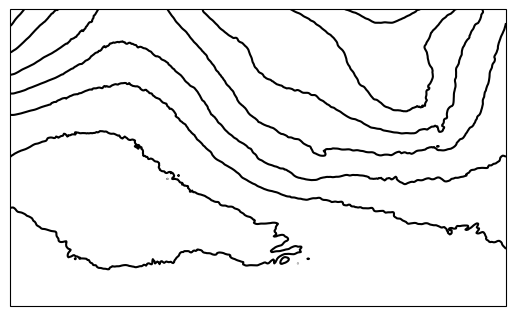

In [17]:
fig2, ax2 = plt.subplots(1,1,subplot_kw={'projection': cart_proj})
levels = np.arange(1000., 1016., 4.)
contours = ax2.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(z_850), colors='black',transform=crs.PlateCarree())

ax2.set_xlim(wrf.cartopy_xlim(u_850))
ax2.set_ylim(wrf.cartopy_ylim(u_850))

plt.show()
plt.close()

In [14]:
u_850

<xarray.DataArray 'ua_interp' (south_north: 265, west_east: 442)> Size: 469kB
array([[ 0.36901623,  0.56772065,  0.7670571 , ..., -3.987285  ,
        -3.8613374 , -3.7341852 ],
       [ 0.90466636,  1.1491153 ,  1.3510927 , ..., -3.3340123 ,
        -3.2000473 , -3.1632423 ],
       [ 1.4265115 ,  1.7031875 ,  1.9545949 , ..., -2.7989233 ,
        -2.6961472 , -2.6850295 ],
       ...,
       [12.711645  , 12.15537   , 11.4246025 , ...,  2.2433083 ,
         1.8127583 ,  1.4218482 ],
       [12.956153  , 12.366713  , 11.66235   , ...,  2.7713852 ,
         2.337234  ,  2.045133  ],
       [13.337101  , 12.832734  , 12.212837  , ...,  3.6852903 ,
         3.2031107 ,  2.8501573 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 469kB -122.2 -122.1 ... -59.88
    XLAT     (south_north, west_east) float32 469kB 22.55 22.58 ... 49.36 49.31
    XTIME    float32 4B 2.52e+03
    Time     datetime64[ns] 8B 2023-07-21T18:00:00
    level    float64 8B 850.0
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:      104
    units:          kt
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     LambertConformal(stand_lon=-97.0, moad_cen_lat=40.0000038...
    missing_value:  9.969209968386869e+36
    _FillValue:     9.969209968386869e+36
    vert_units:     hPa

In [18]:
print(np.count_nonzero(~np.isnan(wrf.to_np(z_850))),wrf.to_np(z_850).size)

117130 117130


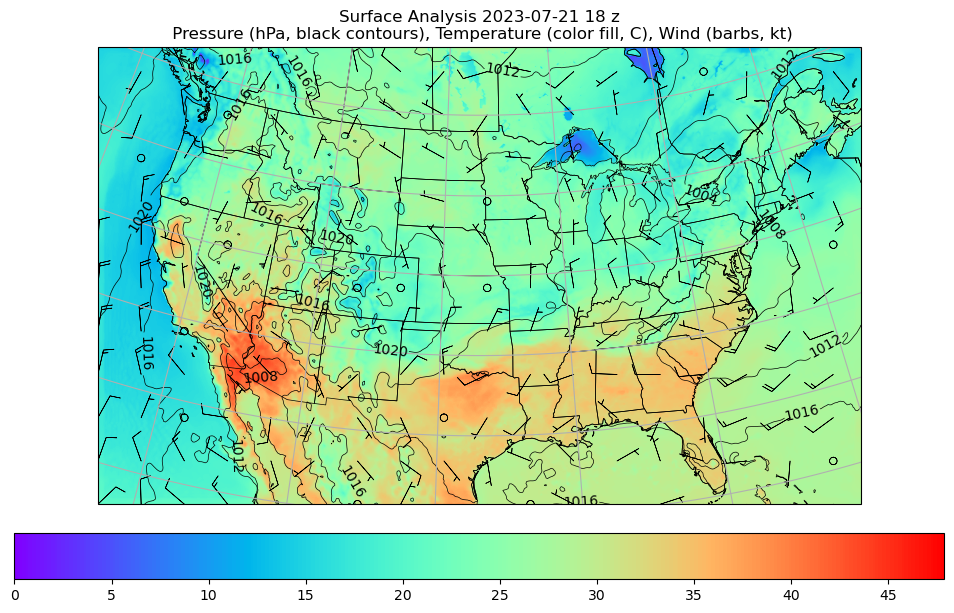

In [12]:
golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)
fig, ax = plt.subplots(1,1, subplot_kw={'projection': cart_proj},figsize=figsize)

#states = NaturalEarthFeature(category='cultural',scale='50m',facecolor='none',name='admin_1_states_provinces')
#lakes = NaturalEarthFeature(category='physical', scale='50m', facecolor='none', name='lakes')
states = cfeature.STATES
ax.add_feature(states, linewidth=0.5, edgecolor='black')
ax.coastlines('50m', linewidth=0.5)




t_levels = np.arange(0., 48., 0.1)
t_contours = ax.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), levels=t_levels, cmap=plt.get_cmap('rainbow'), transform=crs.PlateCarree())
cbar_levels = np.arange(0., 48., 5)
plt.colorbar(t_contours, ax=ax, orientation='horizontal', pad=0.05, ticks=cbar_levels)

levels = np.arange(1004., 1028., 4.)
contours = ax.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(p_10), levels= levels, linewidths= 0.5, colors='black', transform=crs.PlateCarree())
ax.clabel(contours, inline=True, fontsize=10.)
ax.barbs(wrf.to_np(lons[::25, ::25]), wrf.to_np(lats[::25, ::25]), wrf.to_np(u_10[::25, ::25]), wrf.to_np(v_10[::25, ::25]), lw = 0.5, length=6, transform=crs.PlateCarree())

ax.set_xlim(wrf.cartopy_xlim(p_10))
ax.set_ylim(wrf.cartopy_ylim(p_10))

ax.gridlines()

plt.title(f'{"Surface" if plt_type=="sfc" else plt_type} Analysis {year}-{month:02}-{day:02} {hour:02} z\n Pressure (hPa, black contours), Temperature (color fill, C), Wind (barbs, kt)')
plt.savefig(f'{plt_type}-{year}-{month:02}-{day:02}_{hour:02}z.png')
plt.show()
plt.close()